# Bank Marketing Dataset
- The [Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) contains a reasonable large number of data related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal is to predict if the client will subscribe a term deposit.
- It is a fairly large dataset with 41K+ rows, a mixture of categorical and continuous columns as well as data imperfections to identify and manage.

## Dataset
The data has the following columns



Bank client data:

|col num | col name | description |
|:---|:---|:---|
| 1 | age | (numeric) | 
| 2 | job | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') |
| 3 | marital | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) |
| 4 | education | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') |
| 5 | default | has credit in default? (categorical: 'no','yes','unknown') |
| 6 | housing | has housing loan? (categorical: 'no','yes','unknown') |
| 7 | loan | has personal loan? (categorical: 'no','yes','unknown') |

Related with the last contact of the current campaign:

|col num | col name | description |
|:---|:---|:---|
| 8 | contact | contact communication type (categorical: 'cellular','telephone') |
| 9 | month | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') |
| 10 | day_of_week | last contact day of the week (categorical: 'mon','tue','wed','thu','fri') |


Other attributes:

|col num | col name | description |
|:---|:---|:---|
| 11 | campaign | number of contacts performed during this campaign and for this client (numeric, includes last contact) |
| 12 | pdays | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |
| 13 | previous | number of contacts performed before this campaign and for this client (numeric) |
| 14 | poutcome | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') |

Social and economic context attributes:

|col num | col name | description |
|:---|:---|:---|
| 15 | emp.var.rate | employment variation rate - quarterly indicator (numeric) |
| 16 | cons.price.idx | consumer price index - monthly indicator (numeric) |
| 17 | cons.conf.idx | consumer confidence index - monthly indicator (numeric) |
| 18 | euribor3m | euribor 3 month rate - daily indicator (numeric) |
| 19 | nr.employed | number of employees - quarterly indicator (numeric) |

Output variable (desired target):

|col num | col name | description |
|:---|:---|:---|
| 20 | y | This is the target column. Has the client subscribed a term deposit? (binary: 'yes','no') |

## Goal
The goal of this project is 
1. Build and Tune the hyperparameters of a Sklearn model to predict the target column `y` using AWS Sagemaker 
1. Deploy the model as a `Serverless Inference Endpoint` and test it
1. Run `Batch Transform` on the entire input dataset
1. Calculate the performance of the model predictions on the entire input dataset

<a id="table_content"></a>

## Table of Content
- **[1 | Import Libraries](#l)**
- **[2 | Read Dataset](#2)**
- **[3 | Dataset Overview](#3)**
    - **[3.1 | Summary Statistics for Numerical Variables](#3.1)**
    - **[3.2 | Summary Statistics for Categorical Variables](#3.2)**
- **[4 | Univariate Analysis](#4)**
- **[5 | Bivariate Analysis](#5)**
    - **[5.1 | Numerical Features](#5.1)**
    - **[5.2 | Categorical Features](#5.2)**
- **[6 | Data Preprocessing](#6)**
    - **[6.1 | Missing Value Treatment](#6.1)**
    - **[6.2 | Duplicate Values Treatment](#6.2)**
    - **[6.3 | Feature Transformation](#6.3)**
    - **[6.4 | Outlier Treatment](#6.4)**
    - **[6.5 | Categorical Features Encoding](#6.5)**
    - **[6.6 | Handling imbalanced data](#6.6)**
    - **[6.7 | Transforming Skewed Features](#6.7)**
    - **[6.8 | Feature Selectiont](#6.4)**
- **[7 | XGBoost Model Building](#7)**
    - **[7.1 | XGBoost Model Definition](#7.1)**
    - **[7.2 | XGBoost Hyperparameter Tuning](#7.2)**
    - **[7.3 | XGBoost Model Evaluation](#7.3)**
- **[8 | Let's build Pipeline](#8)**
    - **[8.1 | Split out training and testing datasets](#8.1)**
    - **[8.2 | Write the training and testing datasets to S3](#8.2)**
    - **[8.3 | Model Deployement Process - Fit the Pipeline](#8.3)**
    - **[8.4 | Check the training job name](#8.4)**
    - **[8.5 | Hyperparameter Tuning](#8.5)**
- **[9 | Serverless Deployment](#9)**
    - **[9.1 | Invoke the model](#9.1)**
    - **[9.2 | Cleanup](#9.2)**
- **[10 | Batch Transform](#10)**
    - **[10.1 | Trigger Batch Transform Job](#10.1)**
    - **[10.2 | Analyse the predictions](#10.2)**
    - **[10.3 | Cleanup](#10.3)**

<div style="background-color:#ffcccb; border:1px solid red; padding:12px; border-radius:12px"><b>📝 Note:</b> Due to AWS console charges, I have shut down my AWS SageMaker. Please test this notebook in your AWS SageMaker environment.</div>

# 1 | Import Libraries
<a id="1"></a>
 ⬆️[Table Contents](#table_content)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

# 2 | Read Dataset
<a id="2"></a>
 ⬆️[Table Contents](#table_content)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/stephenleo/sagemaker-deployment/main/data/final_project_bank.csv")

print(df.shape)
df.head()

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,NaN,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,NaN,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# 3 | Dataset Overview
<a id="3"></a>
 ⬆️[Table Contents](#table_content)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40767 non-null  float64
 1   job             40704 non-null  object 
 2   marital         40775 non-null  object 
 3   education       40764 non-null  object 
 4   default         40797 non-null  object 
 5   housing         40809 non-null  object 
 6   loan            40733 non-null  object 
 7   contact         40748 non-null  object 
 8   month           40767 non-null  object 
 9   day_of_week     40752 non-null  object 
 10  campaign        40775 non-null  float64
 11  pdays           40739 non-null  float64
 12  previous        40770 non-null  float64
 13  poutcome        40757 non-null  object 
 14  emp.var.rate    40770 non-null  float64
 15  cons.price.idx  40819 non-null  float64
 16  cons.conf.idx   40784 non-null  float64
 17  euribor3m       40759 non-null 

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
  <h2>🏦 Inference 🏦</h2>
    <p><strong>Number of Entries:</strong> The dataset consists of <b>41,188 entries</b></p>
    <p><strong>Columns:</strong> There are <b>20 columns</b> in the dataset corresponding to various attributes.</p>
  <p><strong>Data Types:</strong> Most of the columns (9 out of 20) are of the float64 data type, while the remaining columns are of the object data type.</p>
  <p><strong>Missing Values:</strong> The dataset contains missing values in several columns, ranging from approximately 0.9% to 1.2% of the total entries per column.</p>
      <p><strong>pdays:</strong> This feature based on semantics falls under categorical category.</p>
</div>


In [4]:
# checking for null values 
null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) /len(df) * (100)})
null

,Null Values,Percentage Null Values
age,421,1.022142
job,484,1.175100
marital,413,1.002719
education,424,1.029426
default,391,0.949306
housing,379,0.920171
loan,455,1.104691
contact,440,1.068272
month,421,1.022142
day_of_week,436,1.058561


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
  <h2 >🏦 Null Value Analysis 🏦</h2>

  <p><strong>Columns with Null Values:</strong> Age, job, marital, education, default, housing, loan, contact, month, day_of_week, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, and y have null values.</p>
      <p> We will handle these null values during the data preprocessing step to ensure the integrity and quality of our dataset.</p>
</div>


<a id="3.1"></a>
## 3.1: Summary Statistics for Numerical Variables

In [5]:
# Get the summary statistics for numerical variables
df.drop(columns='pdays').describe().T

,count,mean,std,min,25%,50%,75%,max
age,40767.0,40.021120,10.419903,17.000,32.000,38.000,47.000,98.000
campaign,40775.0,2.566990,2.768760,1.000,1.000,2.000,3.000,56.000
previous,40770.0,0.172823,0.494873,0.000,0.000,0.000,0.000,7.000
emp.var.rate,40770.0,0.082460,1.570749,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,40819.0,93.575781,0.578958,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,40784.0,-40.504127,4.624825,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,40759.0,3.620653,1.734620,0.634,1.344,4.857,4.961,5.045
nr.employed,40751.0,5167.062656,72.224169,4963.600,5099.100,5191.000,5228.100,5228.100


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
  <h2 >🏦 Inference 🏦</h2>
  <ul>
    <li><strong>Age:</strong> The average age of bank clients is approximately <strong>40 years</strong>, with a standard deviation of <strong>10.42 years</strong>. The youngest client is <strong>17 years old</strong>, while the oldest is <strong>98 years old</strong>.</li>
    <li><strong>Campaign:</strong> On average, each client has been contacted approximately <strong>2.57 times</strong> during the campaign, with a maximum of <strong>56 contacts</strong>.</li>
    <li><strong>Previous:</strong> On average, clients have been contacted approximately <strong>0.17 times</strong> before the current campaign, with a maximum of <strong>7 previous contacts</strong>.</li>
    <li><strong>Emp.var.rate:</strong> The employment variation rate has an average value of <strong>0.08</strong>, with a standard deviation of <strong>1.57</strong>. It ranges from <strong>-3.4</strong> to <strong>1.4</strong>.</li>
    <li><strong>Cons.price.idx:</strong> The consumer price index has an average value of <strong>93.58</strong>, ranging from <strong>92.20</strong> to <strong>94.77</strong>.</li>
    <li><strong>Cons.conf.idx:</strong> The consumer confidence index has an average value of <strong>-40.50</strong>, ranging from <strong>-50.80</strong> to <strong>-26.90</strong>.</li>
    <li><strong>Euribor3m:</strong> The average Euribor 3-month rate is approximately <strong>3.62</strong>, with a standard deviation of <strong>1.73</strong>. It ranges from <strong>0.63</strong> to <strong>5.05</strong>.</li>
    <li><strong>Nr.employed:</strong> The average number of employees is approximately <strong>5167</strong>, with a standard deviation of <strong>72.22</strong>. It ranges from <strong>4963.60</strong> to <strong>5228.10</strong>.</li>
  </ul>
</div>


<a id="3.2"></a>
## 3.2: Summary Statistics for Categorical Variables

In [6]:
df['pdays'] = df['pdays'].astype('object')

In [7]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
job,40704,12,admin.,10315
marital,40775,4,married,24670
education,40764,8,university.degree,12039
default,40797,3,no,32274
housing,40809,3,yes,21365
loan,40733,3,no,33575
contact,40748,2,cellular,25847
month,40767,10,may,13625
day_of_week,40752,5,thu,8526
pdays,40739.0,27.0,999.0,39235.0


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
  <h2 >🏦 Inference 🏦</h2>
  <ul>
    <li><strong>Job:</strong> Total unique job categories: 12, Most frequent job category: Admin, with 10,315 occurrences</li>
    <li><strong>Marital:</strong> Total unique marital statuses: 4, Most frequent marital status: Married, with 24,670 occurrences</li>
    <li><strong>Education:</strong> Total unique education levels: 8, Most frequent education level: University degree, with 12,039 occurrences</li>
    <li><strong>Default:</strong> Total unique default statuses: 3, Most frequent default status: No, with 32,274 occurrences</li>
    <li><strong>Housing:</strong> Total unique housing loan statuses: 3, Most frequent housing loan status: Yes, with 21,365 occurrences</li>
    <li><strong>Loan:</strong> Total unique personal loan statuses: 3, Most frequent personal loan status: No, with 33,575 occurrences</li>
    <li><strong>Contact:</strong> Total unique contact types: 2, Most frequent contact type: Cellular, with 25,847 occurrences</li>
    <li><strong>Month:</strong> Total unique months: 10, Most frequent month: May, with 13,625 occurrences</li>
    <li><strong>Day of Week:</strong> Total unique days of the week: 5, Most frequent day: Thursday, with 8,526 occurrences</li>
    <li><strong>pdays:</strong> Total unique previous days: 27, Most frequent day: 999 means client was not previously contacted, with 39,235 occurrences</li>     <li><strong>Previous Outcome:</strong> Total unique previous outcomes: 3, Most frequent outcome: Nonexistent, with 35,188 occurrences</li>
    <li><strong>Term Deposit Subscription(y):</strong> Total unique subscription statuses: 2, Most frequent status: No, with 36,199 occurrences</li>
  </ul>
</div>


# 4 | Univariate Analysis

<a id="4"></a>
 ⬆️[Table Contents](#table_content)

In [8]:
profile = ProfileReport(df)
profile.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 5 | Bivariate Analysis
<a id="5"></a>
 ⬆️[Table Contents](#table_content)

In [9]:
df['y'].value_counts()

y
no     36199
yes     4591
Name: count, dtype: int64

## 5.1 | Numerical Features
<a id="5.1"></a>

In [10]:
cont_cols = list(df.drop(columns='y').describe().columns)


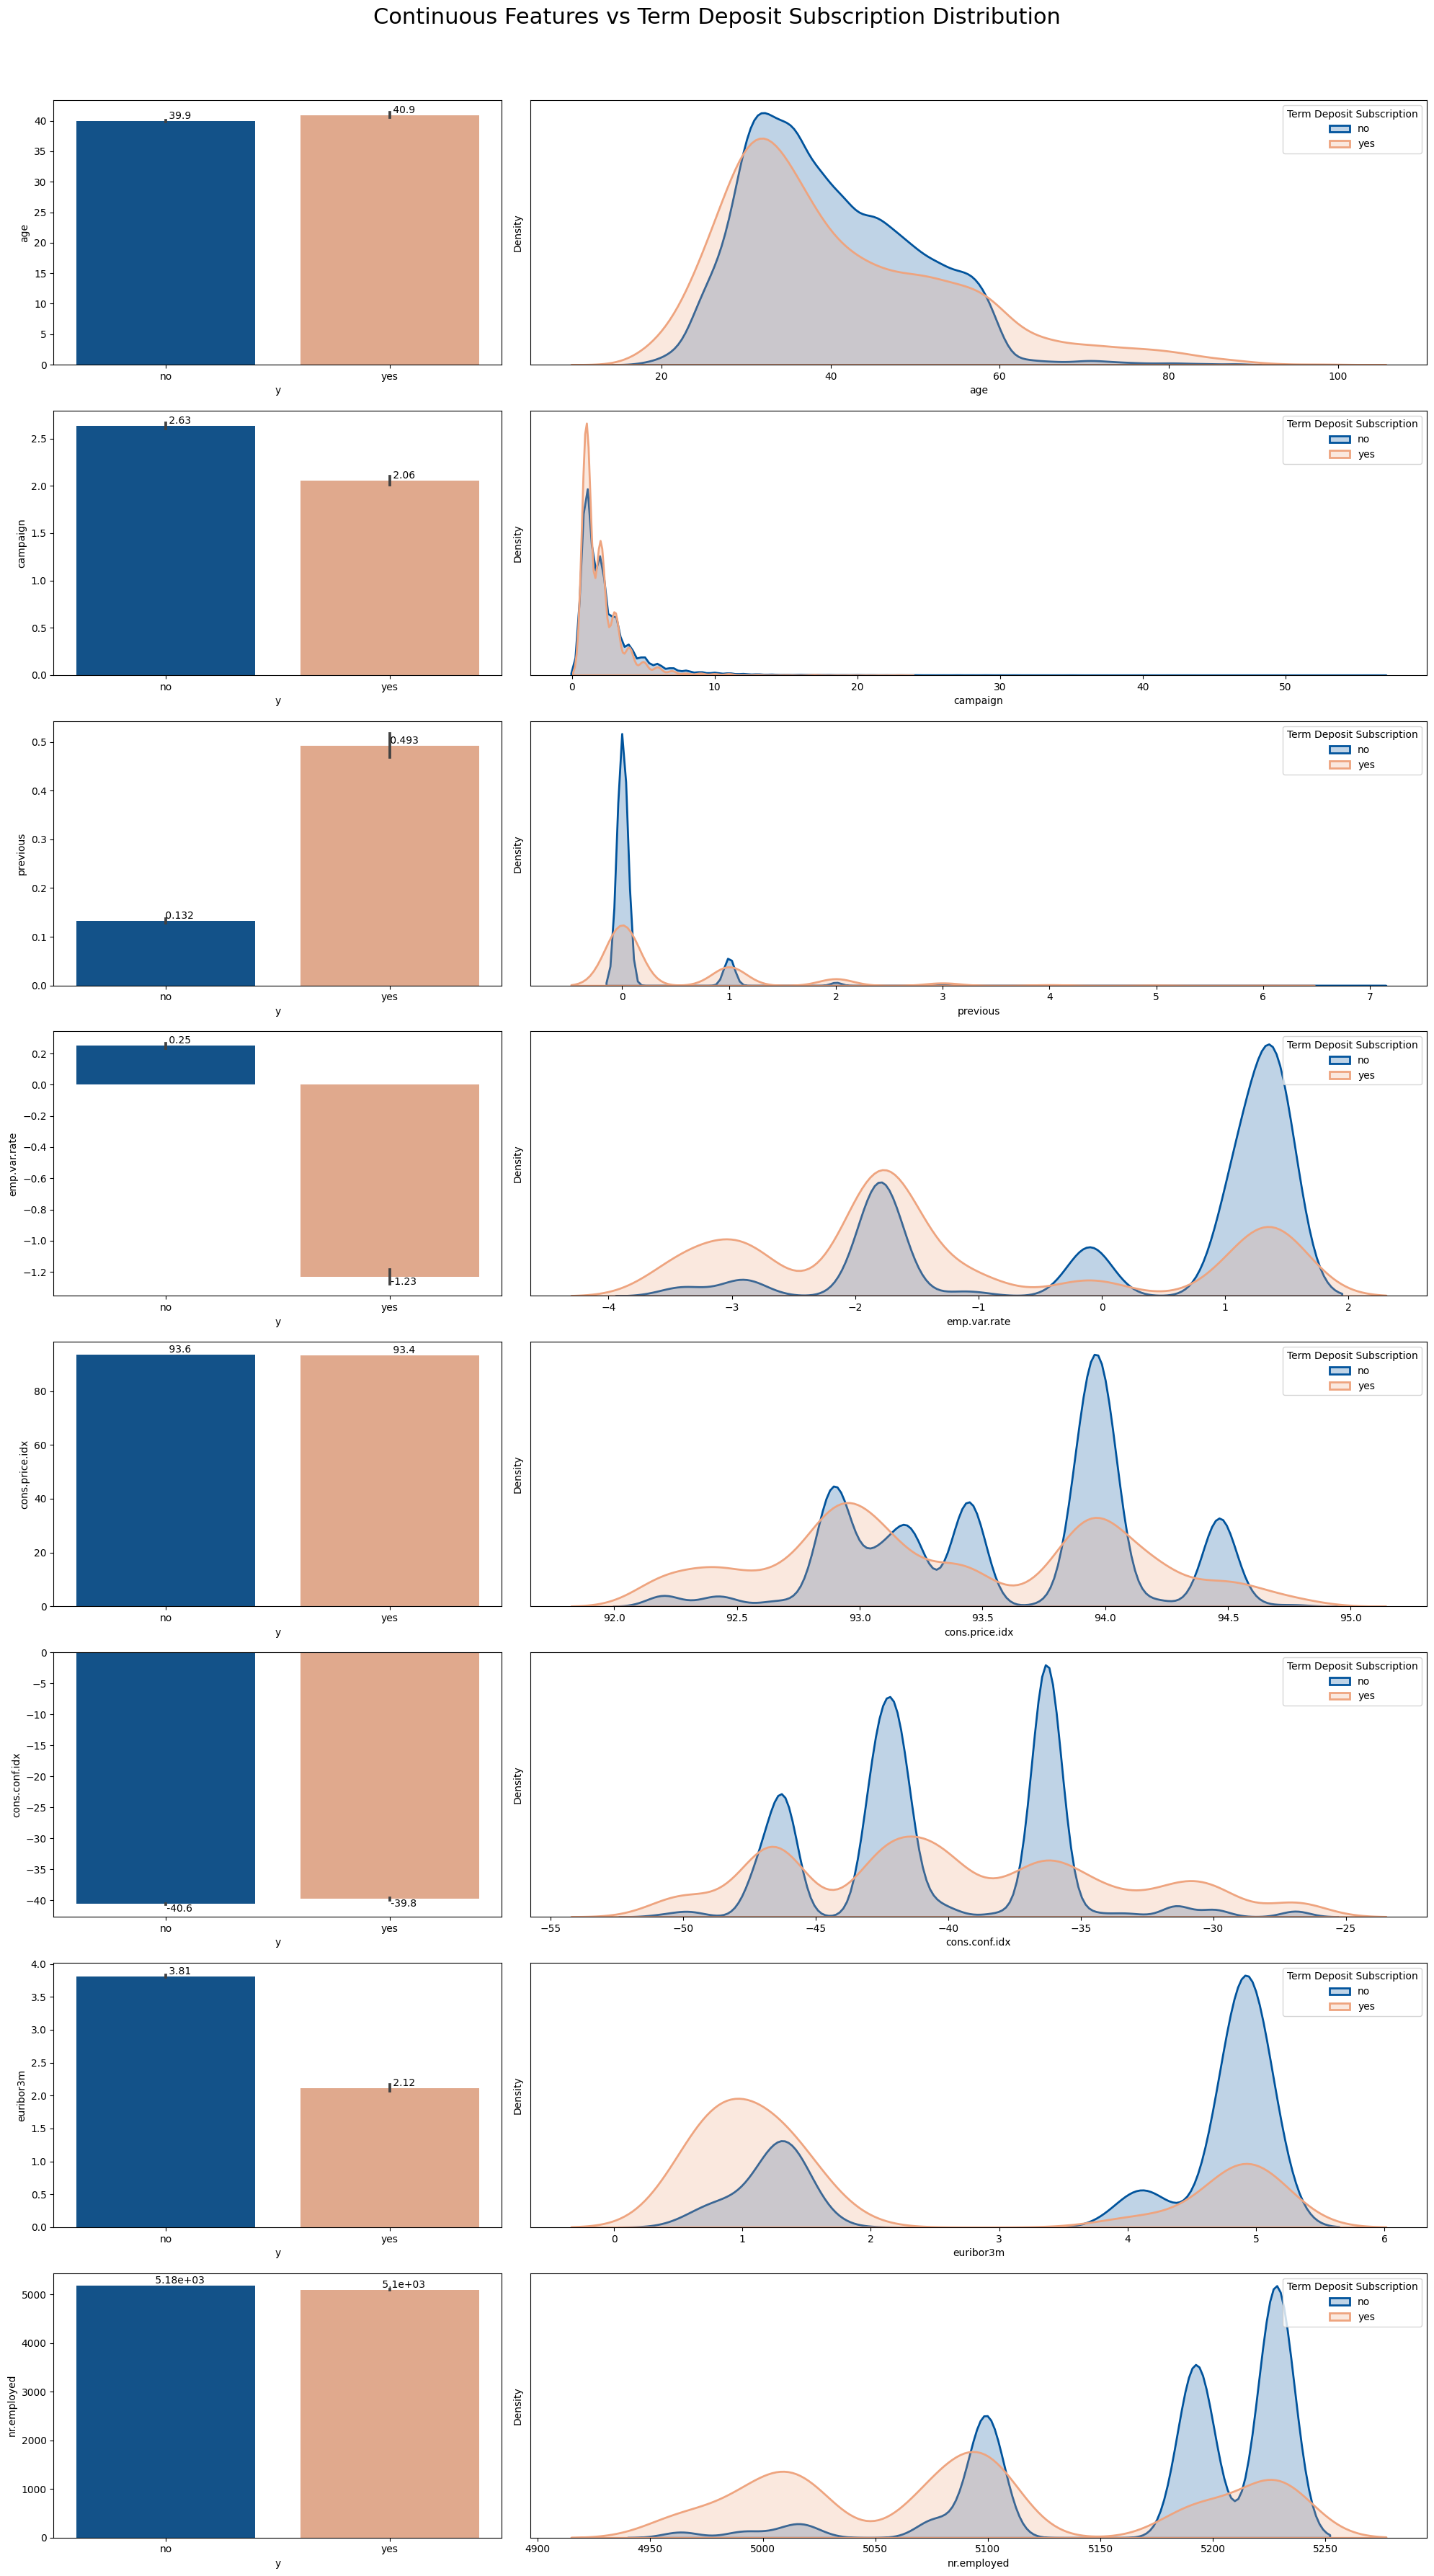

In [11]:
# Set color palette related to wine
sns.set_palette(['#00539cff','#eea47fff'])

# Create the subplots
fig, ax = plt.subplots(len(cont_cols), 2, figsize=(20,35), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(cont_cols):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="y", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["y"]=='no'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='no')
    sns.kdeplot(data=df[df["y"]=='yes'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='yes')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Term Deposit Subscription', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Term Deposit Subscription Distribution', fontsize=22,y=1.02)
plt.tight_layout()                     
plt.show()


## 5.2 | Categorical Features
<a id="5.2"></a>

In [12]:
Cat_Features = list(df.drop(columns='y').describe(include='object').columns)
Cat_Features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'pdays',
 'poutcome']

In [13]:
Target = 'y'

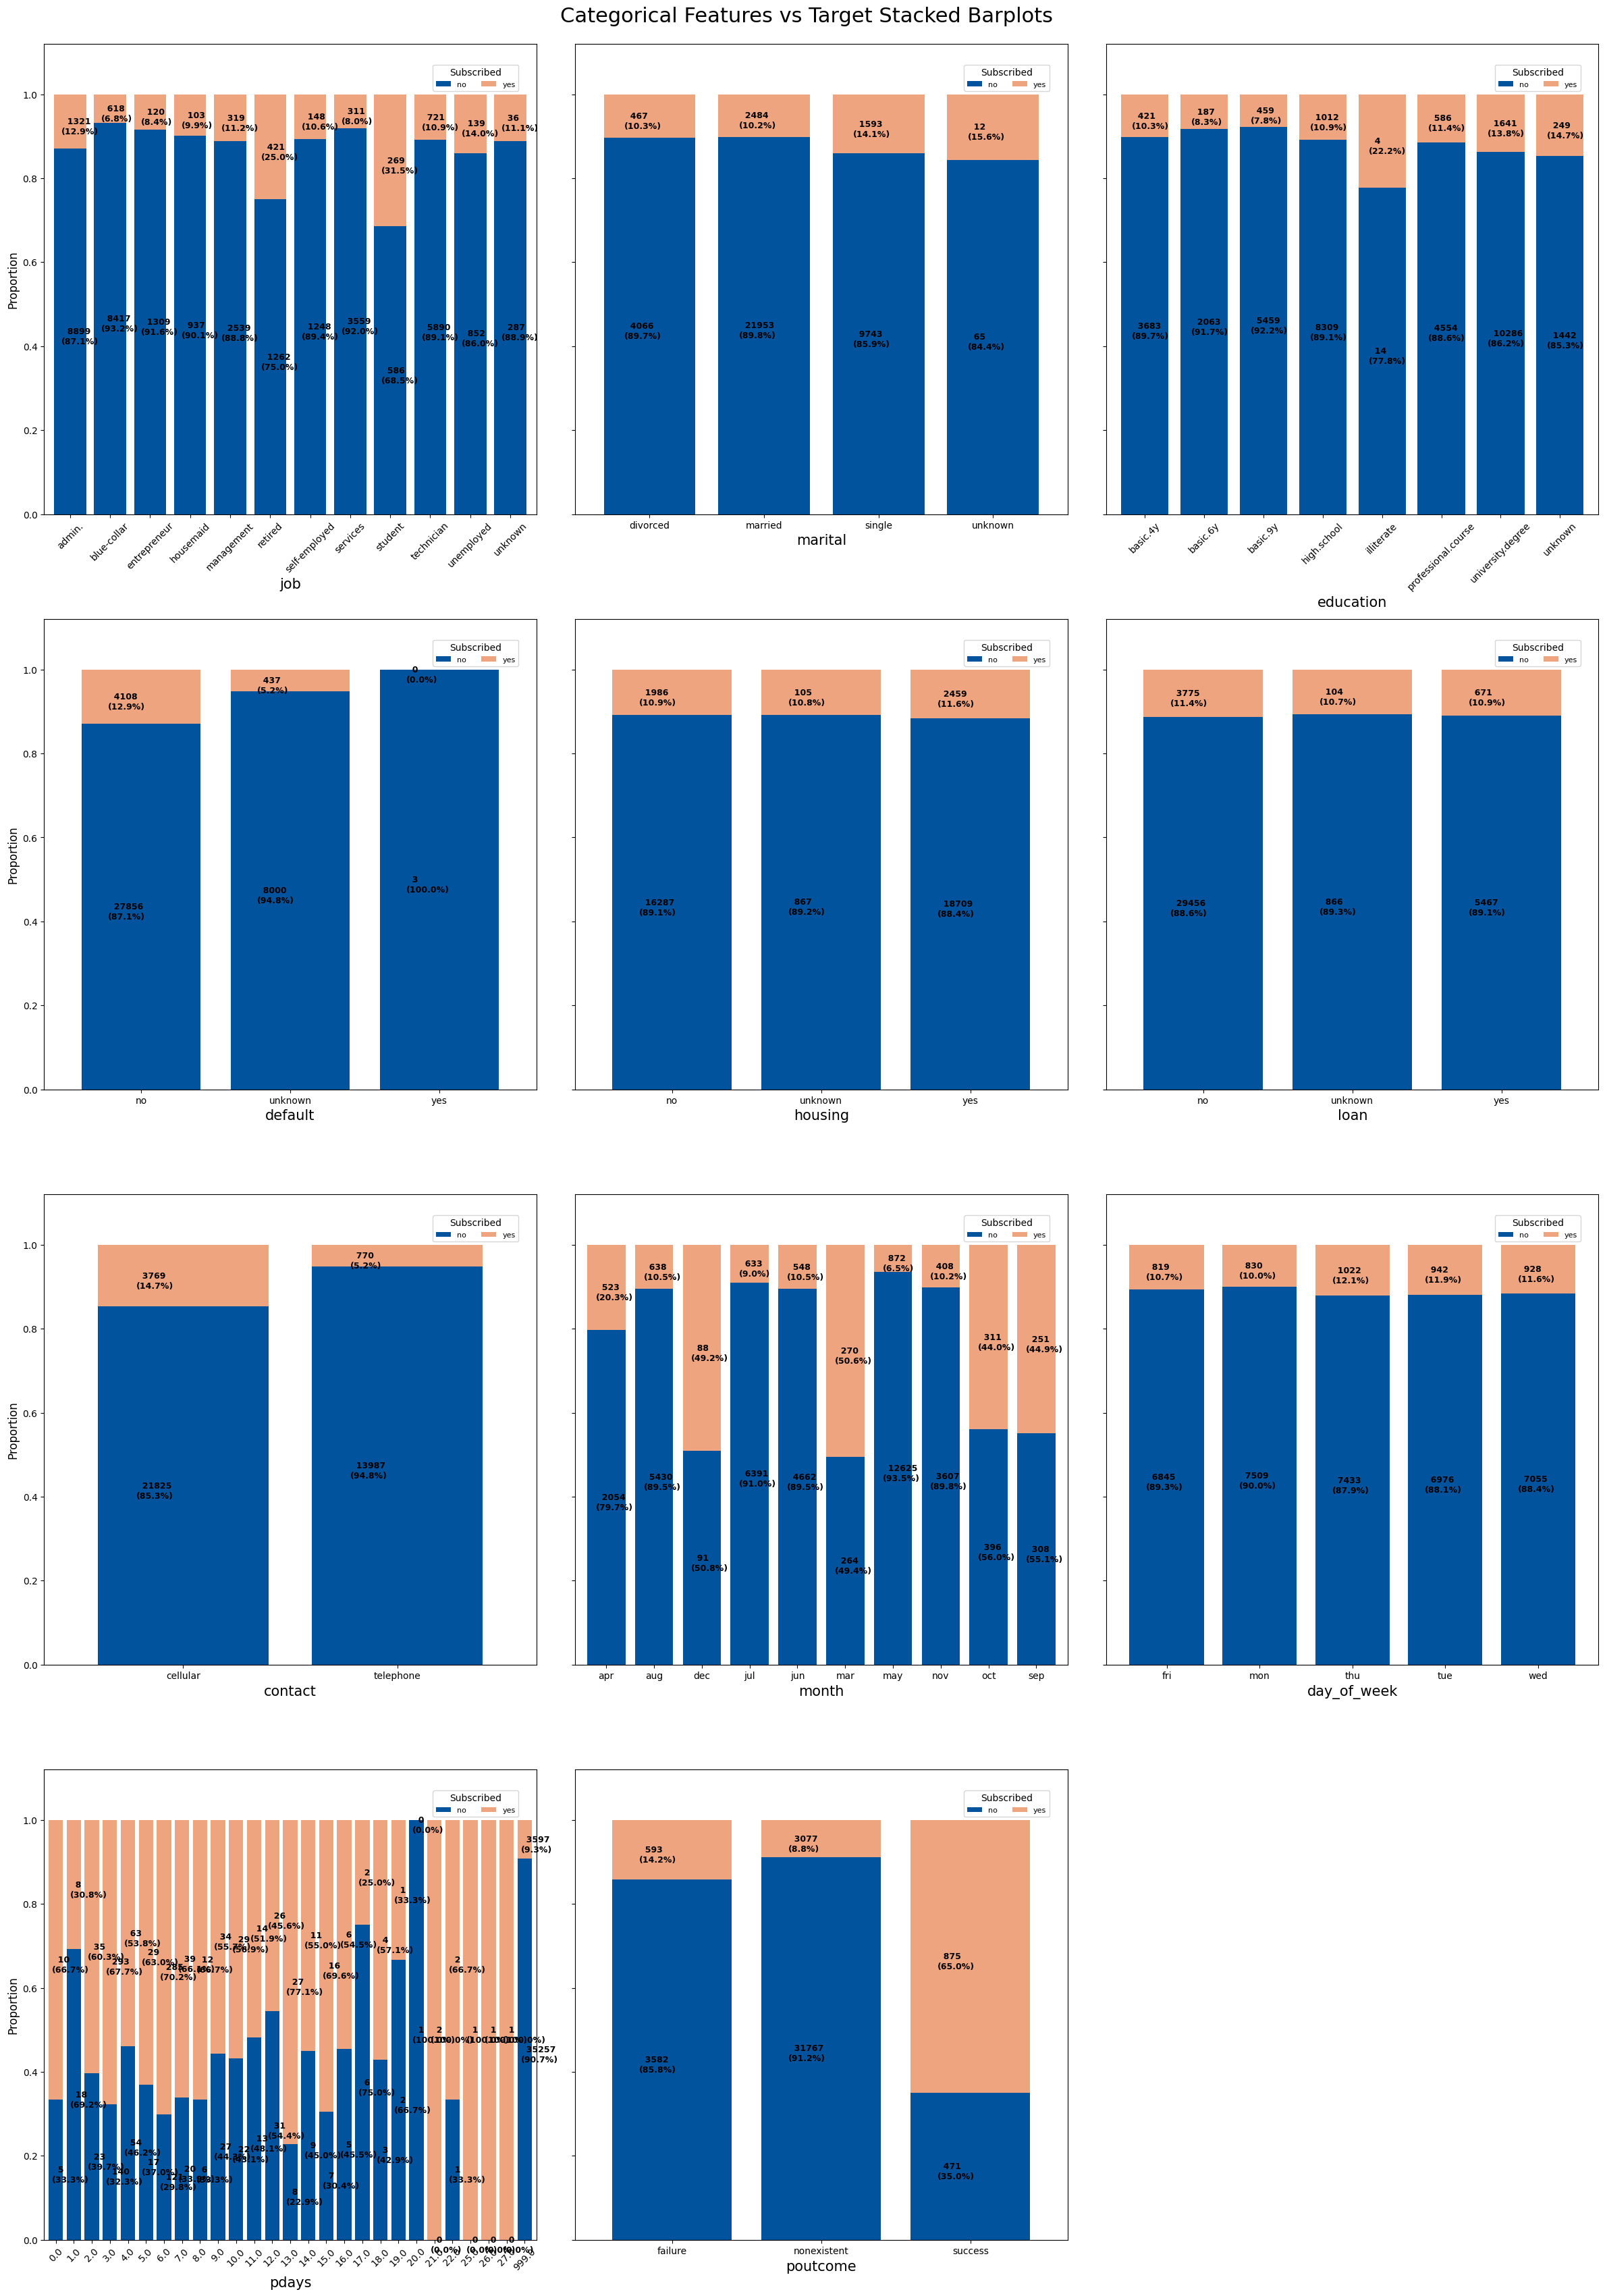

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(24,34))

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of subscription and non-subscriptions of term deposit for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#00539cff','#eea47fff'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Subscribed', loc=(0.79,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    # Increase xlabel & ylabel font sizes
    ax[x,y].set_ylabel('Proportion', fontsize=12)
    ax[x,y].set_xlabel(col, fontsize=15) 
            
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45)  
ax[3, 0].set_xticklabels(ax[3, 0].get_xticklabels(), rotation=45)  
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45) 

ax[3,2].axis('off')

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22,y=0.999)
plt.tight_layout()                     
plt.show()

# 6 | Data Preprocessing
<a id="6"></a>
 ⬆️[Table Contents](#table_content)

## 6.1 |  Missing Value Treatment
<a id="6.1"></a>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
 <p>As seen in Data Overview section, that missing values are between range of  0.9% - 1.2% , which is less than 5%, <b> we will drop the missing values</b></p>
    <div>

In [16]:
df.dropna(inplace=True)

In [17]:
df.isnull().sum().sum()

0

## 6.2 | Duplicate Values Treatment
<a id="6.2"></a>

In [18]:
df.duplicated().sum()

1215

In [19]:
df.drop_duplicates(inplace=True)

## 6.3 | Feature Transformation
<a id="6.3"></a>
<h2 style="color:#00539cff">pdays</h2><br>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">As seen in Bivariate analysis, some categories of pdays were directly associated with target catergory(yes), to handle this will create a new binary feature indicating whether the client was previously contacted</div>

In [20]:
df['previously_contacted'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)

# Drop the original "pdays" feature if it's no longer needed
df.drop(columns=['pdays'], inplace=True)

<h2 style="color:#00539cff">default</h2><br>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">As seen in Bivariate analysis, <b>yes</b> category of 'default' is  directly associated with target catergory(no),to handle this, will create a new binary feature indicating whether default status is known or unknown</div>

In [21]:
df['default_known'] = df['default'].map({'yes': 1, 'no': 1, 'unknown': 0})

In [22]:
# Drop the original "default" feature
df.drop('default', axis=1, inplace=True)

## 6.4 | Outlier Treatment
<a id="6.4"></a>

In [23]:
Q1 = df[cont_cols].quantile(0.25)
Q3 = df[cont_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[cont_cols] < (Q1 - 1.5 * IQR)) | (df[cont_cols] > (Q3 + 1.5 * IQR))).sum()

In [24]:
outliers_count_specified

age                373
campaign          1975
previous          4525
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      347
euribor3m            0
nr.employed          0
dtype: int64

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
    <p>Upon identifying outliers for the specified continuous features, we found the following:</p>
    <ul>
        <li><b>age :</b> 373 outliers</li>
        <li><b>campaign :</b> 1975 outliers</li>
        <li><b>previous :</b> 4525 outliers</li>
        <li><b>emp.var.rate :</b> 0 outliers</li>
        <li><b>cons.price.idx :</b> 0 outliers</li>
        <li><b>cons.conf.idx :</b> 347 outliers</li>
        <li><b>euribor3m :</b> 0 outliers</li>
        <li><b>nr.employed :</b> 0 outliers</li>
    </ul>
</div>


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
    <h3>Sensitivity to Outliers:</h3>
    <ul>
        <li><b>SVM (Support Vector Machine):</b> SVMs can be sensitive to outliers. While the decision boundary is determined primarily by the support vectors, outliers can influence which data points are chosen as support vectors, potentially leading to suboptimal classification.</li>
        <li><b>Decision Trees (DT) and Random Forests (RF):</b> These tree-based algorithms are generally robust to outliers. They make splits based on feature values, and outliers often end up in leaf nodes, having minimal impact on the overall decision-making process.</li>
        <li><b>K-Nearest Neighbors (KNN):</b> KNN is sensitive to outliers because it relies on distances between data points to make predictions. Outliers can distort these distances.</li>
        <li><b>AdaBoost:</b> This ensemble method, which often uses decision trees as weak learners, is generally robust to outliers. However, the iterative nature of AdaBoost can sometimes lead to overemphasis on outliers, making the final model more sensitive to them.</li>
    </ul>

<p>Given the nature of the algorithms (especially SVM and KNN), direct removal of outliers might not be the best approach. Instead, we'll focus on applying <b>Winsorization</b> for the <b>cons.conf.idx</b> feature since it contains negative values in its distribution. Winsorization will help mitigate the impact of outliers and make the data more suitable for modeling in the subsequent steps.</p>
    

<p><b>Box-Cox</b> is better compared to <b>Winsorization</b>, since Winsorization may lead to <b>loss of information</b>, especially if the <b>outliers</b> contain <b>valuable insights</b> or <b>important patterns</b>.</p>
</div>


## 6.5 | Categorical Features Encoding
<a id="6.5"></a>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
  <h3>One-hot Encoding Decision:</h3>
  <p>Based on the feature descriptions, let's decide on one-hot encoding:</p>
  <ul>
    <li><strong>Nominal Variables:</strong> These are variables with no inherent order. They should be one-hot encoded because using them as numbers might introduce an unintended order to the model.</li>
    <li><strong>Ordinal Variables:</strong> These variables have an inherent order. They don't necessarily need to be one-hot encoded since their order can provide meaningful information to the model.</li>
  </ul>
  <p><strong>Given the above explanation:</strong></p>
  <p>The following features are nominal variables and should be one-hot encoded:</p>
  <ul>
    <li><strong>job:</strong> This is a nominal variable with two categories.</li>
    <li><strong>marital:</strong> This is a nominal variable.</li>
    <li><strong>housing:</strong> This is a nominal variable.</li>
    <li><strong>loan:</strong> This is a nominal variable.</li>
    <li><strong>contact:</strong> This is a nominal variable.</li>
    <li><strong>poutcome:</strong> This is a nominal variable.</li>
  </ul>
  <p>The following feature is an ordinal variable and should be label encoded:</p>
  <ul>
      <li><strong>month</strong> and <strong>day_of_week:</strong> This is an ordinal variable (months and week days have a natural order).</li>
      <li><strong>education</strong> This is an ordinal variable</li>
  </ul>


In [25]:
# Convert 'arrival_date_month' to numerical values
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = df['month'].apply(lambda x: months.index(x) + 1)

In [26]:
week_days = ['mon', 'tue', 'wed', 'thu', 'fri','sat','sun']
df['day_of_week'] = df['day_of_week'].apply(lambda x: week_days.index(x) + 1)

In [27]:
df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [28]:
print("Proportion of 'unknown' values in the 'education' feature:",len(df[df['education'] =='unknown'])/len(df))

Proportion of 'unknown' values in the 'education' feature: 0.04324659231722429


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
To address the presence of 'unknown' values in the 'education' feature, we've decided to drop this category from our analysis. With approximately 4.32% of the data falling under the 'unknown' category, it's a relatively small portion of the dataset. By removing these instances, we ensure a more accurate representation of the education levels of our clients.

In [29]:
# Drop rows with 'unknown' education
df = df[df['education'] != 'unknown']

In [30]:
df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'],
      dtype=object)

In [31]:
# Define ordinal mapping
education_mapping = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}

# Map education categories to ordinal values
df['education'] = df['education'].map(education_mapping)

In [32]:
df.describe(include='object').columns

Index(['job', 'marital', 'housing', 'loan', 'contact', 'poutcome', 'y'], dtype='object')

In [33]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['job', 'marital', 'housing', 'loan', 'contact', 'poutcome'], drop_first=True, dtype=int)

In [34]:
df_encoded.shape

(30884, 35)

In [35]:
df_encoded.dtypes

age                     float64
education                 int64
month                     int64
day_of_week               int64
campaign                float64
previous                float64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
y                        object
previously_contacted      int64
default_known             int64
job_blue-collar           int32
job_entrepreneur          int32
job_housemaid             int32
job_management            int32
job_retired               int32
job_self-employed         int32
job_services              int32
job_student               int32
job_technician            int32
job_unemployed            int32
job_unknown               int32
marital_married           int32
marital_single            int32
marital_unknown           int32
housing_unknown           int32
housing_yes               int32
loan_unknown              int32
loan_yes

In [36]:
df_encoded.head()

,age,education,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,marital_married,marital_single,marital_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,56.0,1,5,1,1.0,0.0,1.1,93.994,-36.4,4.857,...,1,0,0,0,0,0,0,1,1,0
2,37.0,4,5,1,1.0,0.0,1.1,93.994,-36.4,4.857,...,1,0,0,0,1,0,0,1,1,0
3,40.0,2,5,1,1.0,0.0,1.1,93.994,-36.4,4.857,...,1,0,0,0,0,0,0,1,1,0
5,45.0,3,5,1,1.0,0.0,1.1,93.994,-36.4,4.857,...,1,0,0,0,0,0,0,1,1,0
6,59.0,5,5,1,1.0,0.0,1.1,93.994,-36.4,4.857,...,1,0,0,0,0,0,0,1,1,0


In [37]:
df_encoded['y'] = df_encoded['y'].map({'yes':1, 'no':0})

In [38]:
df_encoded['y'].value_counts()

y
0    27334
1     3550
Name: count, dtype: int64

## 6.6 | Handling Imbalanced dataset
<a id="6.6"></a>

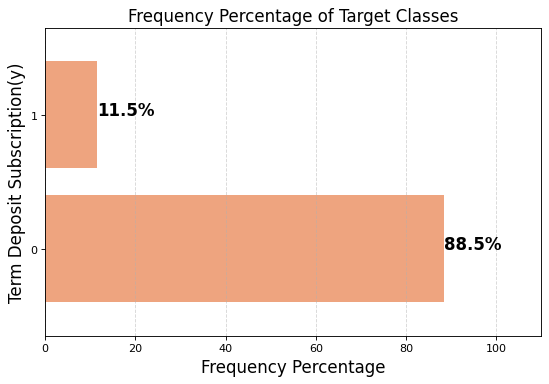

In [39]:
plt.figure(dpi=80)
# Plot frequency percentages barplot
ax = df_encoded['y'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5), color="#eea47fff")

# Add frequency percentages to the plot
labels = df_encoded['y'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    ax.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Term Deposit Subscription(y)', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Remove outer grid
plt.show()


<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;"><p>As can be seen, <b>the dataset we are working on is imbalanced.</b></p>
    <h3>Problems with Imbalanced Datasets:</h3>
    <ol>
        <li>Imbalanced datasets can lead to algorithms that are biased towards the majority class. This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.</li><br>
<li>The performance of a machine learning model can become highly skewed when it is fed with imbalanced data. For example, our dataset has 88.5% class 0 and 11.5% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 91.2% accuracy!</li><br>
<li>If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.</li>
    </ol>
    <p><span style="font-size:13pt; font-weight:600">To Handle this</span>, we will use this, we will use <b>SMOTE (Synthetic Minority Over-sampling Technique)</b>. SMOTE is a technique used to generate synthetic samples for the minority class in order to balance the class distribution in the dataset. By creating synthetic samples, SMOTE helps mitigate the impact of class imbalance and improves the performance of machine learning models in predicting the minority class.</p>
</div>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">
    <p>The approach for <b>model evaluation</b> when dealing with <b>imbalanced datasets</b> is to use appropriate metrics including <b>recall, precision, F1 score</b> and <b>AUC(area under curve)</b> that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.</p>
    <p>In this project, the main goal is to classify potential clients who are more likely to subscribe a term deposit. The metrics used to evaluate the performance of the model will be important in determining how well the model is able to identify these potential subscribers.</p>
    <ul>
        <li><b>Recall</b> is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential subscribers.</li>
        <li><b>Precision</b> is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because a high precision indicates that when the model predicts a client will subscribe to a term deposit, it is likely to be correct.</li>
        <li><b>F1-score</b> is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.</li>
       </ul>
    <p style="color:#00539cff;">For this project, both recall and precision for the positive class (class '1', representing clients who subscribe to a term deposit) are crucial metrics. Therefore, the <b>F1-score for class '1'</b> should be considered the most important metric. A high F1-score signifies a balance between identifying as many potential term deposit subscribers as possible (high recall) and minimizing the number of false positives (high precision). This balance is essential for the <b>bank's objective of increasing the conversion rate of depositors to term deposit subscribers while simultaneously reducing the cost of the marketing campaign.</b></p>
       

<h2 style="color:#00539cff">
Using SMOTE</h2><br>

In [40]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_encoded.drop('y', axis=1), df_encoded['y'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [41]:
# Define the features (X) and the output labels (y)
X = oversampled.drop(['y'], axis = 1)
y = oversampled['y']

In [42]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 6.7 | Transforming Skewed Features
<a id="6.7"></a>

In [43]:
from scipy.stats import mstats

# Apply Winsorization to skewed columns
for col in cont_cols:
    X_train[col] = mstats.winsorize(X_train[col], limits=(0.01, 0.01))
    X_test[col] = mstats.winsorize(X_test[col], limits=(0.01, 0.01))


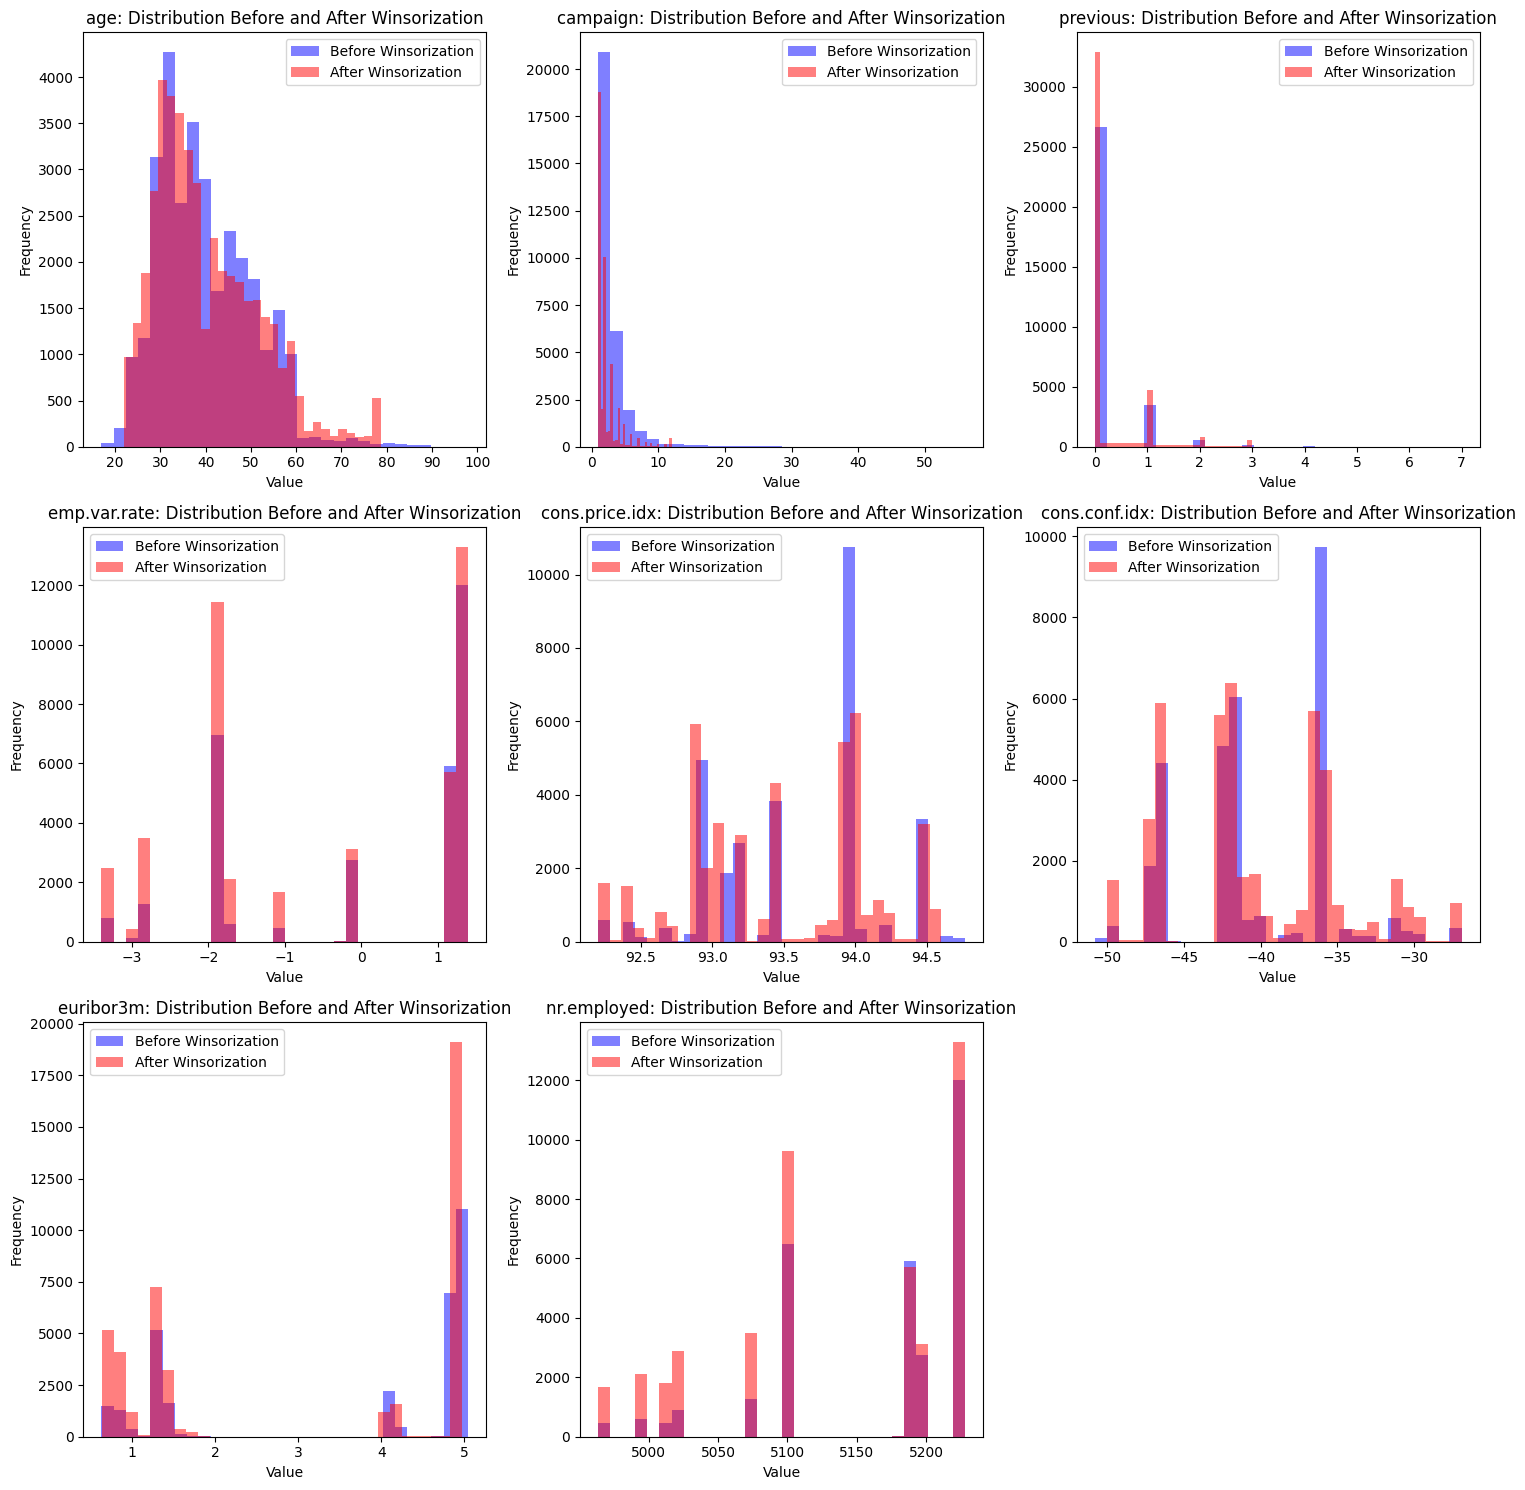

In [44]:
# Define the number of columns per row in the plot matrix
num_cols_per_row = 3

# Calculate the number of rows needed for the plot matrix
num_rows = (len(cont_cols) + num_cols_per_row - 1) // num_cols_per_row

# Create subplots for each column
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 5 * num_rows))

# Flatten the axes array if it's not already flat
axes = axes.flatten()

# Plot histograms of the columns before and after Winsorization
for i, col in enumerate(cont_cols):
    ax = axes[i]
    ax.hist(df[col], bins=30, color='blue', alpha=0.5, label='Before Winsorization')
    ax.hist(X_train[col], bins=30, color='red', alpha=0.5, label='After Winsorization')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col}: Distribution Before and After Winsorization')
    ax.legend()

# Hide empty subplots
for j in range(len(cont_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 6.8 | Feature Selection
<a id="6.8"></a>

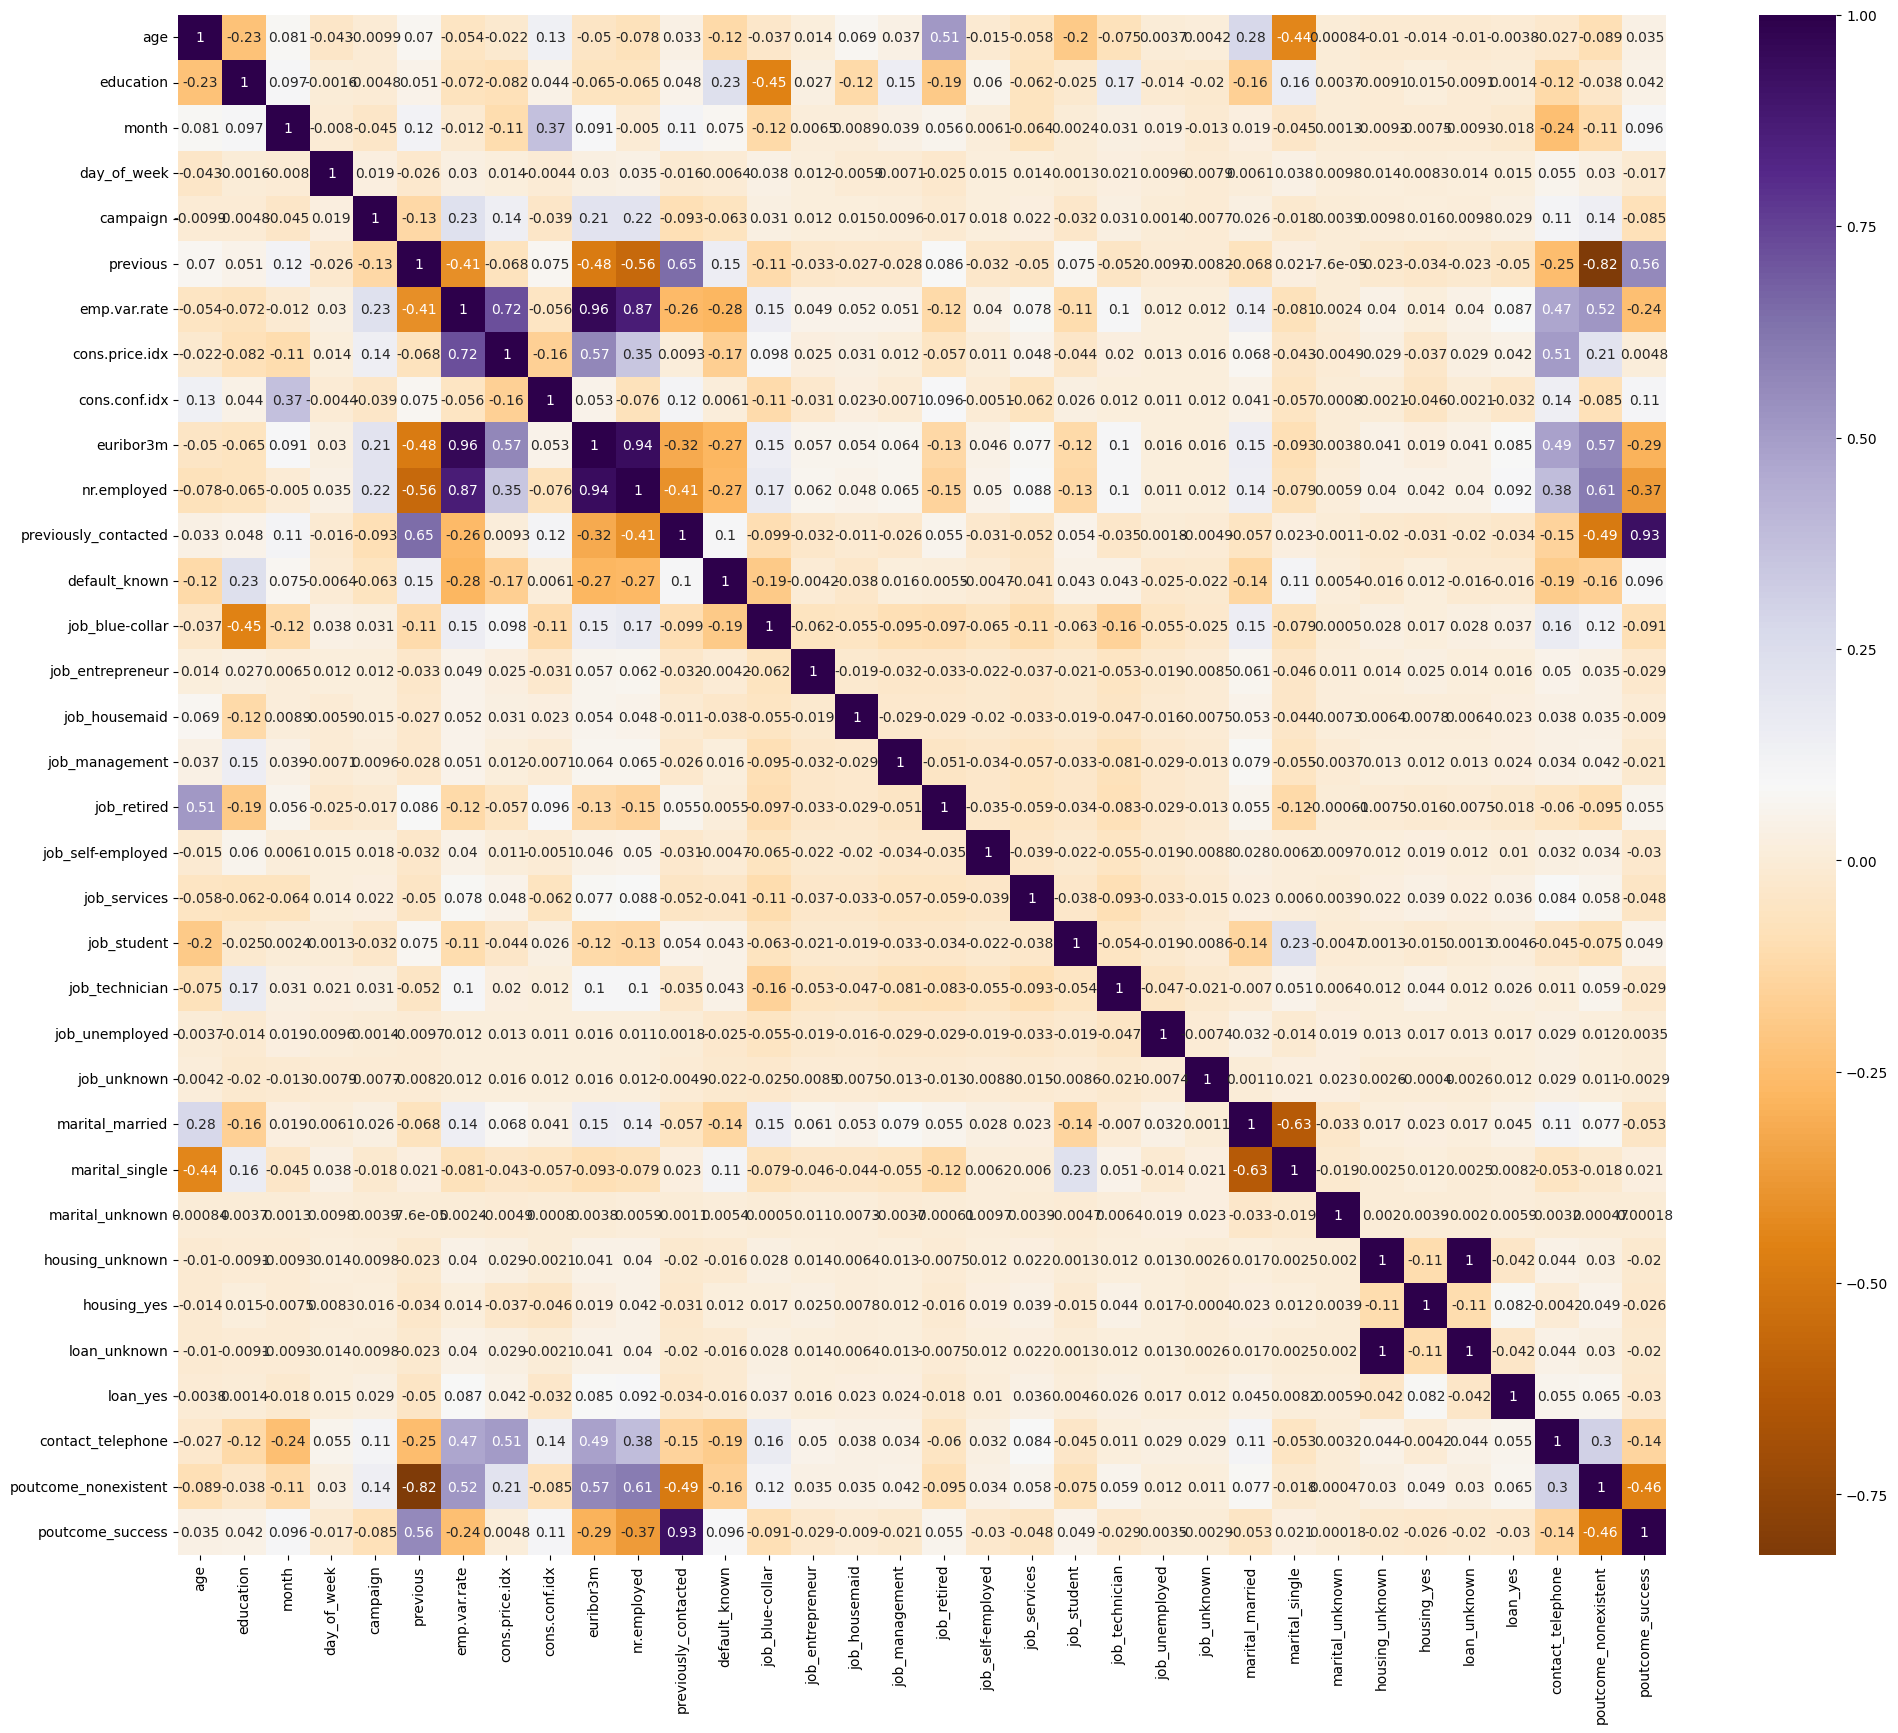

In [45]:
#Using Pearson Correlation
plt.figure(figsize=(24,20))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.PuOr)
plt.show()

In [46]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [47]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

6

In [48]:
corr_features

{'cons.price.idx',
 'euribor3m',
 'loan_unknown',
 'nr.employed',
 'poutcome_nonexistent',
 'poutcome_success'}

In [49]:
X_train.drop(corr_features,axis=1,inplace=True)
X_test.drop(corr_features,axis=1, inplace=True)

# 7 | XGBoost Model Building
<a id="7"></a>
 ⬆️[Table Contents](#table_content)

## 7.1 | XGBoost Model Definition
<a id="7.1"></a>

In [50]:
# Define the base DT model
xgb = XGBClassifier(random_state=0)

## 7.2 | XGBoost Hyperparameter Tuning
<a id="7.2"></a>

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">Building a XGBoostclassifier is easy, but improving the model requires hyperparameter tuning. There are several methods for hyperparameter tuning in XGBoost, such as grid search, random search, and Bayesian optimization. We will define a function that finds the optimal combination of hyperparameters to achieve the best accuracy using GridSearchCV and Cross-validation (StratifiedKFold) :

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;"><p>I am establishing a function to determine the optimal set of hyperparameters that yield the highest <b>f1-score</b> for the model. This approach ensures a reusable framework for hyperparameter tuning of subsequent models</p>
    

In [51]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">I'll set up the hyperparameters grid and utilize the <b>tune_clf_hyperparameters</b> function to pinpoint the optimal hyperparameters for our DT model:

<div style="background-color: #f0f0f0; border: 2px solid #ccc; padding: 20px; border-radius: 10px;">
  <p>Hyperparameter tuning is essential in XGBoost classifier to optimize the performance of the model. XGBoost has several hyperparameters that can be tuned to achieve the best possible performance for a given problem.</p>

  <p><strong>XGBoost Hyperparameters:</strong></p>
  <ul>
    <li><strong>eta (Learning rate):</strong> Step size shrinkage used in updates to prevent overfitting.</li>
    <li><strong>max_depth:</strong> Maximum tree depth for base learners. Increasing this value will make the model more complex and more likely to overfit.</li>
    <li><strong>gamma:</strong> Minimum loss reduction required to make a further partition on a leaf node of the tree.</li>
    <li><strong>lambda (reg_lambda):</strong> L2 regularization term on weights. Increasing this value will make the model more conservative.</li>
    <li><strong>alpha (reg_alpha):</strong> L1 regularization term on weights. Increasing this value will force more feature selection.</li>
    <li><strong>subsample:</strong> Subsample ratio of the training instances. Setting it to a value less than 1 will make the model more random.</li>
    <li><strong>colsample_bytree:</strong> Subsample ratio of columns when constructing each tree.</li>
    <li><strong>colsample_bylevel:</strong> Subsample ratio of columns for each level.</li>
    <li><strong>n_estimators:</strong> Number of trees in the forest.</li>
    <li><strong>max_leaf_nodes:</strong> Maximum number of terminal nodes or leaves in a tree.</li>
    <li><strong>max_delta_step:</strong> Maximum delta step for each leaf. It's used for further control over the range of values of weight for each instance.</li>
    <li><strong>scale_pos_weight:</strong> It is the ratio of number of negative class to the positive class and controls the balance of positive and negative weights, useful for unbalanced classes.</li>
    <li><strong>min_child_weight:</strong> Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process will give up further partitioning.</li>
    <li><strong>booster:</strong> The underlying model used by XGBoost, either tree-based (gbtree) or linear (gblinear). Tree-based booster always outperforms the linear booster and thus the later is rarely used.</li>
    <li><strong>Objective:</strong> Defines the loss function used to evaluate the performance of the model.</li>
    <li><strong>eval_metric:</strong> Specifies the metric used to judge the performance of the model during training and testing.</li>
  </ul>
</div>


In [52]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

<div style="background-color: #ebe9df;border:2px solid #dbc7d5; padding: 20px; border-radius: 10px;">Due to the large number of XGBoost hyperparameters, the process of finding optimal hyperparameters will be very time-consuming. For this reason, we made the set of grid values smaller and finally we got the following optimal combination of hyperparameters for our XGBoost classifier:



In [63]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=6,
                        learning_rate=0.1,
                        n_estimators=300,
                        min_child_weight=5,
                        colsample_bytree=0.6,
                        gamma=0.2,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

## 7.3 | XGBoost Model Evaluation
<a id="7.3"></a>

In [54]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [55]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for validation test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     21867
           1       0.95      0.90      0.92     21867

    accuracy                           0.92     43734
   macro avg       0.93      0.92      0.92     43734
weighted avg       0.93      0.92      0.92     43734


	   Classification report for validation test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5467
           1       0.93      0.89      0.91      5467

    accuracy                           0.91     10934
   macro avg       0.91      0.91      0.91     10934
weighted avg       0.91      0.91      0.91     10934



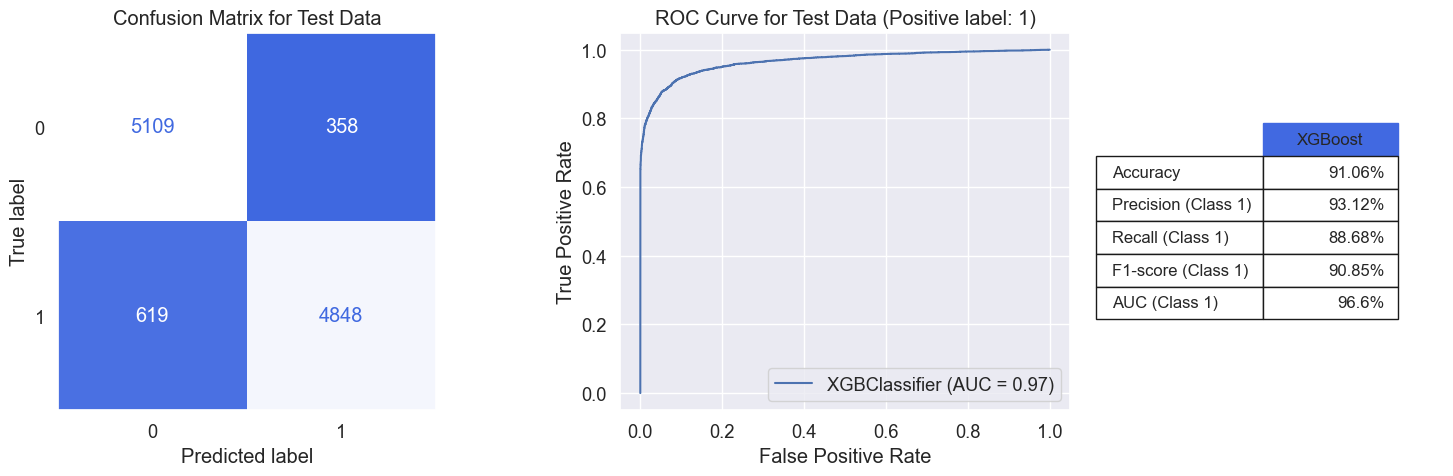

In [64]:
model_evaluation(xgb_opt, X_train, X_test, y_train, y_test, 'XGBoost')

# 8 | Let's build Pipeline
<a id="8"></a>
 ⬆️[Table Contents](#table_content)

## 8.1 | Split out training and testing datasets
<a id="8.1"></a>

In [57]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print(train_df.shape, test_df.shape)
train_df.head()

(27795, 20) (3089, 20)


,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previously_contacted,default_known
28065,32.0,blue-collar,married,3,unknown,unknown,telephone,4,5,3.0,0.0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no,0,1
6204,35.0,blue-collar,married,1,yes,no,telephone,5,2,4.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,1
15776,22.0,blue-collar,single,3,yes,yes,cellular,7,1,1.0,0.0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,yes,0,1
40230,40.0,management,married,6,yes,no,cellular,7,4,4.0,0.0,nonexistent,-1.7,94.215,-40.3,0.884,4991.6,yes,0,1
27239,52.0,entrepreneur,married,6,yes,yes,cellular,11,5,2.0,0.0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no,0,1


In [58]:
# Create a big dataset to test out batch inference later
big_test_df = test_df.sample(500_000, replace=True, ignore_index=True)

print(big_test_df.shape)
big_test_df.head()

(500000, 20)


,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previously_contacted,default_known
0,37.0,technician,single,5,yes,no,cellular,5,5,3.0,0.0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no,0,1
1,24.0,student,single,3,yes,no,cellular,4,2,1.0,0.0,nonexistent,-1.8,93.749,-34.6,0.646,5008.7,no,0,1
2,50.0,unemployed,married,5,yes,yes,cellular,7,4,1.0,0.0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0,0
3,31.0,unemployed,single,6,yes,no,cellular,3,2,1.0,1.0,success,-1.8,93.369,-34.8,0.646,5008.7,yes,1,1
4,53.0,management,married,6,yes,yes,telephone,8,5,1.0,0.0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,0,1


## 8.2 |  Write the training and testing datasets to S3
<a id="8.2"></a>

In [ ]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

In [ ]:
# Write the files locally
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)
big_test_df.to_json("../data/bigtest.json", orient="records", lines=True)

In [ ]:
# Send the files to S3
train_path = session.upload_data(
    path="../data/train.csv", bucket=bucket, key_prefix="sagemaker/subscriber_class"
)

test_path = session.upload_data(
    path="../data/test.csv", bucket=bucket, key_prefix="sagemaker/subscriber_class"
)

bigtest_path = session.upload_data(
    path="../data/bigtest.json", bucket=bucket, key_prefix="sagemaker/subscriber_class"
)

print(f"Train path: {train_path}")
print(f"Test path: {test_path}")
print(f"Big Test path: {bigtest_path}")

## 8.3 | Model Deployement Process - Fit the Pipeline
<a id="8.3"></a>

In [ ]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import mstats

model_file_name = "pipeline_model.joblib"

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def handle_missing_values(train_df, test_df):
    if train_df.isnull().sum().any() or test_df.isnull().sum().any():
        print("Missing values found. Please handle missing values before proceeding.")
        return None
    return train_df, test_df

def drop_duplicates(train_df, test_df):
    train_df.drop_duplicates(inplace=True)
    test_df.drop_duplicates(inplace=True)
    return train_df, test_df

def transform_pdays(train_df, test_df):
    train_df['previously_contacted'] = train_df['pdays'].apply(lambda x: 1 if x != 999 else 0)
    test_df['previously_contacted'] = test_df['pdays'].apply(lambda x: 1 if x != 999 else 0)
    train_df.drop(columns=['pdays'], inplace=True)
    test_df.drop(columns=['pdays'], inplace=True)
    return train_df, test_df

def transform_default(train_df, test_df):
    train_df['default_known'] = train_df['default'].map({'yes': 1, 'no': 1, 'unknown': 0})
    test_df['default_known'] = test_df['default'].map({'yes': 1, 'no': 1, 'unknown': 0})
    train_df.drop(columns=['default'], inplace=True)
    test_df.drop(columns=['default'], inplace=True)
    return train_df, test_df

def detect_outliers(train_df, cont_cols):
    Q1 = train_df[cont_cols].quantile(0.25)
    Q3 = train_df[cont_cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers_count_specified = ((train_df[cont_cols] < (Q1 - 1.5 * IQR)) | (train_df[cont_cols] > (Q3 + 1.5 * IQR))).sum()
    return outliers_count_specified

def apply_winsorization(train_df, test_df, cont_cols):
    train_df[cont_cols] = mstats.winsorize(train_df[cont_cols], limits=(0.01, 0.01))
    test_df[cont_cols] = mstats.winsorize(test_df[cont_cols], limits=(0.01, 0.01))
    return train_df, test_df

def encode_categorical(train_df, test_df):
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    train_df['month'] = train_df['month'].apply(lambda x: months.index(x) + 1)
    test_df['month'] = test_df['month'].apply(lambda x: months.index(x) + 1)

    week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    train_df['day_of_week'] = train_df['day_of_week'].apply(lambda x: week_days.index(x) + 1)
    test_df['day_of_week'] = test_df['day_of_week'].apply(lambda x: week_days.index(x) + 1)

    train_df = train_df[train_df['education'] != 'unknown']
    test_df = test_df[test_df['education'] != 'unknown']

    education_mapping = {'illiterate': 0, 'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3, 'high.school': 4,
                         'professional.course': 5, 'university.degree': 6}
    train_df['education'] = train_df['education'].map(education_mapping)
    test_df['education'] = test_df['education'].map(education_mapping)

    train_df_encoded = pd.get_dummies(train_df, columns=['job', 'marital', 'housing', 'loan', 'contact', 'poutcome'],
                                      drop_first=True, dtype=int)
    test_df_encoded = pd.get_dummies(test_df, columns=['job', 'marital', 'housing', 'loan', 'contact', 'poutcome'],
                                     drop_first=True, dtype=int)
    return train_df_encoded, test_df_encoded

def check_class_imbalance(y_train):
    ratio = sum(y_train == 0) / sum(y_train == 1)
    return ratio < 5

def oversample_data(X_train, y_train):
    oversampler = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

def remove_correlated_features(X_train, X_test, threshold=0.7):
    col_corr = set()  
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    X_train.drop(col_corr, axis=1, inplace=True)
    X_test.drop(col_corr, axis=1, inplace=True)
    return X_train, X_test

def train_model(X_train, y_train, max_depth=6, learning_rate=0.1, n_estimators=100, min_child_weight=5, gamma=0.2):
    xgb_opt = XGBClassifier(max_depth=max_depth,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                min_child_weight=min_child_weight,
                                gamma=gamma,
                                booster='gbtree',
                                objective='binary:logistic',
                                eval_metric='error', 
                                random_state=0)
    
    pipeline_xgb_model = Pipeline([
        ("XGBoost model", xgb_opt)
    ])
    
    pipeline_xgb_model.fit(X_train, y_train)
    return pipeline_xgb_model

def save_model(model, model_dir, model_file_name):
    model_save_path = os.path.join(model_dir, model_file_name)
    joblib.dump(model, model_save_path)
    print(f"Model saved at {model_save_path}")

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--max_depth", type=int, default=6)
    parser.add_argument("--learning_rate", type=float, default=0.1)
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--min_child_weight", type=float, default=5)
    parser.add_argument("--gamma", type=float, default=0.2)
    args, _ = parser.parse_known_args()

    train_df, test_df = load_data(train_path, test_path)
    train_df, test_df = handle_missing_values(train_df, test_df)
    if train_df is None:
        return

    train_df, test_df = drop_duplicates(train_df, test_df)
    train_df, test_df = transform_pdays(train_df, test_df)
    train_df, test_df = transform_default(train_df, test_df)

    cont_cols = ['age','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
    outliers_count_specified = detect_outliers(train_df, cont_cols)
    if outliers_count_specified.any():
        train_df, test_df = apply_winsorization(train_df, test_df, cont_cols)

    train_df_encoded, test_df_encoded = encode_categorical(train_df, test_df)

    X_train = train_df_encoded.drop("y", axis=1)
    y_train = train_df_encoded["y"].map({'yes':1, 'no':0})
    X_test = test_df_encoded.drop("y", axis=1)
    y_test = test_df_encoded["y"].map({'yes':1, 'no':0})

    if check_class_imbalance(y_train):
        X_train, y_train = oversample_data(X_train, y_train)
    
    X_train, X_test = remove_correlated_features(X_train, X_test)

    model = train_model(X_train, y_train, max_depth=args.max_depth, learning_rate=args.learning_rate, n_estimators=args.n_estimators, min_child_weight=args.min_child_weight, gamma=args.gemma)
    
    train_accuracy = model.score(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    test_accuracy = model.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy:.4f}")

    save_model(model, args.model_dir, model_file_name)

if __name__ == "__main__":
    main()


In [61]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
fsspec
s3fs

In [ ]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

sklearn_estimator = SKLearn(
    base_job_name="xgb-pipeline-run",
    framework_version="0.23-1",
    entry_point="train.py",
    dependencies=["requirements.txt"],
    hyperparameters={
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 300,
        "min_child_weight": 5,
        "gamma": 0.2
    },
    instance_count=1,
    instance_type="ml.m5.large",
    use_spot_instances=True,
    max_wait=600,
    max_run=600,
    role=get_execution_role(),
)

# Launch Training job
sklearn_estimator.fit()


## 8.4 | Check the training job name
<a id="8.4"></a>

In [ ]:
import boto3
sm_client = boto3.client("sagemaker")

training_job_name = sklearn_estimator.latest_training_job.name

# Obtain the location of the model stored on S3 - Optional
# You can directly copy the location of the artifact from S3 also!
model_artifact = sm_client.describe_training_job(
    TrainingJobName=training_job_name
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Training job name: {training_job_name}")
print(f"Model storage location: {model_artifact}")

## 8.5 | Hyperparameter Tuning
<a id="8.5"></a>

In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "max_depth": IntegerParameter(1, 10),
    "learning_rate": ContinuousParameter(0.01, 0.5),
    "n_estimators": IntegerParameter(50, 300),
    "min_child_weight": IntegerParameter(1, 10),
    "gamma": ContinuousParameter(0, 1)
}

# Create optimizer
optimizer = HyperparameterTuner(
    base_tuning_job_name="xgb-pipeline-tuner",
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type="Maximize",
    objective_metric_name="test-accuracy",
    metric_definitions=[
        {"Name": "train-accuracy", "Regex": "Training Accuracy: ([0-9.]+).*$"},
        {"Name": "test-accuracy", "Regex": "Testing Accuracy: ([0-9.]+).*$"}
    ],
    max_jobs=10,
    max_parallel_jobs=2,
)

# Launch Optimizer job
optimizer.fit()


# 9 | Serverless Deployment
<a id="9"></a>
 ⬆️[Table Contents](#table_content)

In [ ]:
%%writefile serve.py

import os
import joblib
import pandas as pd

def model_fn(model_dir):
    """Load and return the model"""
    model_file_name = "pipeline_model.joblib"
    pipeline_model = joblib.load(os.path.join(model_dir, model_file_name))
    
    return pipeline_model

def input_fn(request_body, request_content_type):
    """Process the input json data and return the processed data.
    you can also add any input data pre-processing in this function"""
    if request_content_type == "application/json":
        input_object = pd.read_json(request_body, lines=True)
        
        return input_object
    else:
        raise ValueError("Only application/json content type supported!")

def predict_fn(input_object, pipeline_model):
    """Make predictions on processed input data"""
    predictions = pipeline_model.predict(input_data)
    pred_probs = pipeline_model.predict_proba(input_object)
    
    prediction_object = pd.DataFrame(
        {
            "prediction": predictions.tolist(),
            "pred_prob_class0": pred_probs[:, 0].tolist(),
            "pred_prob_class1": pred_probs[:, 1].tolist()
        }
    )
    
    return prediction_object

def output_fn(prediction_object, request_content_type):
    """Post process the predictions and return as json"""
    return_object = prediction_object.to_json(orient="records", lines=True)
    
    return return_object

In [ ]:
# Create the deployment
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import Session, get_execution_role

session = Session()
bucket = session.default_bucket()

training_job_name = "..." # TODO: Update with best TrainingJobName from hyperparameter tuning
model_artifact = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"
endpoint_name = "subscriber-predict-xgb-pipeline-real-time"

model = SKLearnModel(
    name=endpoint_name,
    framework_version="1.0-1",
    entry_point="serve.py",
    dependencies=["requirements.txt"],
    model_data=model_artifact,
    role=get_execution_role(),
)

In [ ]:
# Create a config for serverless inference
from sagemaker.serverless import ServerlessInferenceConfig
serverless_config = ServerlessInferenceConfig(memory_size_in_mb=1024, max_concurrency=4)

In [ ]:
# Deploy!
predictor = model.deploy(serverless_inference_config=serverless_config)

In [ ]:
endpoint_name = predictor.endpoint_name
print("Endpoint name:")
print(f"{endpoint_name}")

## 9.1 | Invoke the model
<a id="9.1"></a>

In [ ]:
import pandas as pd

test_df = pd.read_csv(test_path) # TODO: Paste the S3 path to your test.csv

X_test = test_df.drop("y", axis=1)
y_test = test_df["y"].map({'yes':1, 'no':0})

# Get two rows to make predictions on
X_pred = X_test.head(2).to_json(orient="records", lines=True)
X_pred

In [ ]:
# Submit to the endpoint
import boto3

sm_runtime = boto3.client("sagemaker-runtime")

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                      Body=X_pred, 
                                      ContentType="application/json", 
                                      Accept="application/json")

In [ ]:
# Decode the response from the endpoint
response_body = response['Body']
response_str = response_body.read().decode('utf-8')
response_df = pd.read_json(response_str, lines=True)

response_df

## 9.2 | Cleanup
<a id="9.2"></a>

In [ ]:
import boto3

def cleanup(endpoint_name):
    sm_client = boto3.client("sagemaker")

    # Get the model name from endpoint_name
    response = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)

    # Delete the endpoint
    sm_client.delete_endpoint(EndpointName=endpoint_name)

    # Delete the endpoint config
    endpoint_config_name = response['EndpointConfigName']
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)                        

    # Delete the model
    model_name = response['ProductionVariants'][0]['ModelName']
    sm_client.delete_model(ModelName=model_name)

In [ ]:
# Run the cleanup
cleanup(endpoint_name)

# 10 | Batch Transform
<a id="10"></a>
 ⬆️[Table Contents](#table_content)

## 10.1 | Trigger Batch Transform Job
<a id="10.1"></a>

In [ ]:
# Create the deployment
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import get_execution_role, Session

session = Session()
bucket = session.default_bucket()

training_job_name = "..." # TODO: Update with best TrainingJobName from hyperparameter tuning
model_artifact = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"
endpoint_name = "subscriber-predict-xgb-pipeline-real-time"

model = SKLearnModel(
    name=endpoint_name,
    framework_version="1.0-1",
    entry_point="serve.py",
    dependencies=["requirements.txt"],
    model_data=model_artifact,
    role=get_execution_role(),
    sagemaker_session=session
)

In [ ]:
# Create a batch tranformer from the base model
output_path = f"s3://{bucket}/sagemaker/subscriber/test_preds"
batch_transformer = model.transformer(instance_count=2,
                                     instance_type="ml.m5.large",
                                     strategy="MultiRecord",
                                     accept="application/json",
                                     assemble_with="Line",
                                     output_path=output_path)

In [ ]:
%%time
# Feed the test data
test_data_path = "..."# TODO: Paste the S3 path to your bigtest.json
batch_transformer.transform(test_data_path, content_type="application/json", split_type="Line")

In [ ]:
# Print the output path
output_path = f"{batch_transformer.output_path}/bigtest.json.out"
print("Output written to: ")
print(f"{output_path}")

## 10.2 | Analyse the predictions
<a id="10.2"></a>

In [ ]:
import pandas as pd
output_path = f"{batch_transformer.output_path}/bigtest.json.out"
preds_df = pd.read_json(output_path, lines=True)

print(preds_df.shape)
preds_df.head()

In [ ]:
# Join predictions to input
bigtest = "../data/bigtest.json"
bigtest_df = pd.read_json(bigtest, lines=True)

bigtest_df = bigtest_df.join(preds_df)
bigtest_df['y'] = bigtest_df['y'].map({'yes':1, 'no':0})
bigtest_df.head()


In [ ]:
# Calculate test accuracy
len(bigtest_df[bigtest_df['y']==bigtest_df["prediction"]])/len(bigtest_df)

## 10.3 | Cleanup
<a id="10.3"></a>

In [ ]:
import boto3

sm_client = boto3.client("sagemaker")
sm_client.delete_model(ModelName=endpoint_name)

# Thank you!!